In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append("../src")
import exlib
from exlib.datasets.chestxdet import ChestXDetDataset, ChestXDetModel, ChestXDetMetric

## Overview
* The objective is to predict the **pathology** regions (atelectasis, calcification, etc. Total 13).
* The higher-level features are the anatomical **structures** (left clavicle, right clavicle, etc. Total 14).

In [2]:
dataset = ChestXDetDataset(split="test")
pathols_model = ChestXDetModel.from_pretrained("BrachioLab/chestxdet_pathols").eval()
structs_model = ChestXDetModel.from_pretrained("BrachioLab/chestxdet_structs").eval()

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

In [3]:
## Dataset samples and model predictions

In [4]:
torch.manual_seed(105)
for i in torch.randperm(len(dataset)):
    sample = dataset[i.item()]
    image, pathols, structs = sample["image"], sample["pathols"], sample["structs"]
    if pathols.sum() > 0 and structs.sum() > 0:
        break

with torch.no_grad():
    pathols_pred = (pathols_model(image[None,...]).logits[0] > 0).long()
    structs_pred = (structs_model(image[None,...]).logits[0] > 0).long()

## True labels vs pre-trained model predictions

<Figure size 640x480 with 0 Axes>

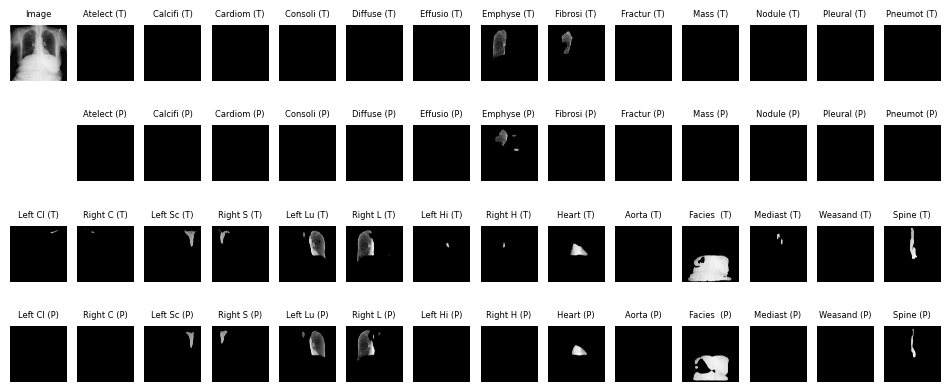

In [5]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    (["image"] + [f"pathol{i}t" for i in range(13)]),
    (["."] + [f"pathol{i}p" for i in range(13)]),
    [f"struct{i}t" for i in range(14)],
    [f"struct{i}p" for i in range(14)],
], figsize=(12,5))

for _, a in ax.items(): a.set_axis_off()
ax["image"].imshow(image.numpy().transpose(1,2,0), cmap="gray")

pathol_titles = ChestXDetDataset.pathology_names
struct_titles = ChestXDetDataset.structure_names
ax["image"].imshow(image.numpy().transpose(1,2,0), cmap="gray")
fs = 6
ax["image"].set_title("Image", fontsize=fs)

for i in range(13):
    mask_t = pathols[i].unsqueeze(0)
    mask_p = (pathols_pred[i]).unsqueeze(0)
    ax[f"pathol{i}t"].imshow(((image * mask_t).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"pathol{i}p"].imshow(((image * mask_p).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"pathol{i}t"].set_title(f"{pathol_titles[i][:7]} (T)", fontsize=fs)
    ax[f"pathol{i}p"].set_title(f"{pathol_titles[i][:7]} (P)", fontsize=fs)

for i in range(14):
    mask_t = structs[i].unsqueeze(0)
    mask_p = (structs_pred[i]).unsqueeze(0)
    ax[f"struct{i}t"].imshow(((image * mask_t).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"struct{i}p"].imshow(((image * mask_p).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"struct{i}t"].set_title(f"{struct_titles[i][:7]} (T)", fontsize=fs)
    ax[f"struct{i}p"].set_title(f"{struct_titles[i][:7]} (P)", fontsize=fs)

Unfortunately, our pre-trained models aren't so good at pathology segmentation, but maybe you can do better!

## How well are the higher-level feature alignments?
Let's first define another simple grid-based higher-level feature model

In [6]:
class GridHighLevelFeatures(nn.Module):
    # Let's assume image is 1024x1024 and make 32x32 grids (i.e., 32x32 partitions)
    def __init__(self):
        super().__init__()

    def forward(self, x):
        N, _, _, _ = x.shape
        mask_small = torch.tensor(range(8*8)).view(1,1,8,8).repeat(N,1,1,1)
        mask_big = F.interpolate(mask_small.float(), scale_factor=128).round().long()
        return mask_big.view(N,1024,1024)

In [7]:
metric = ChestXDetMetric()
grid_model = GridHighLevelFeatures()
torch.manual_seed(1234)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
pretrained_scores, grid_scores = [], []
for i, item in enumerate(tqdm(dataloader)):
    image = item["image"]
    with torch.no_grad():
        structs_true_masks = item["structs"]
        pretrained_masks = (structs_model(image).logits > 0).long()
        grid_masks = F.one_hot(grid_model(image)).permute(0,3,1,2)
        pretrained_score = metric(pretrained_masks, structs_true_masks) # (N,H,W)
        grid_score = metric(grid_masks, structs_true_masks) # (N,H,W)
        pretrained_scores.append(pretrained_score.mean(dim=(1,2)))
        grid_scores.append(grid_score.mean(dim=(1,2)))
        
    if i > 20:
        break

pretrained_scores = torch.cat(pretrained_scores)
grid_scores = torch.cat(grid_scores)

print(f"Avg alignment of pretrained model: {pretrained_scores.mean():.4f}")
print(f"Avg alignment of grid model: {grid_scores.mean():.4f}")

 15%|█▌        | 21/139 [11:38<1:05:24, 33.26s/it]

Avg alignment of pretrained model: 0.3401
Avg alignment of grid model: 0.0688
